In [22]:
import torchvision
import torchvision.models.detection as detection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader
import torch.optim as optim
import torch


def get_transform(train):
    transform = [transforms.ToTensor()]
    return transforms.Compose(transform)


class Kitti(torchvision.datasets.Kitti):
    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        # Convert target format from list of dicts to the correct dict format
        labels = [1 + ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare'].index(t['type']) for t in target]
        boxes = [t['bbox'] for t in target]
        
        target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4), 'labels': torch.as_tensor(labels)}
        return image, target

# Now get, and show a sample data from the kitti dataset class defined above
dataset = Kitti(download=True, root='./data', transform=get_transform(train=True))
sample = dataset[0]
image, target = sample
# print(sample)
print(image.shape)
print(target)
# print(target['boxes'])
print(target['labels'])
print(target['boxes'].shape)
print(target['labels'].shape)

print(Kitti.__len__(dataset))

torch.Size([3, 375, 1242])
{'boxes': tensor([[572.4400, 181.5600, 611.9500, 219.7100],
        [498.8500, 149.4900, 551.4000, 204.3200],
        [ 56.4600, 195.8900, 220.7800, 260.9100],
        [321.0800, 188.6500, 383.5200, 221.9300],
        [280.4000, 183.3500, 291.9000, 212.5600]]), 'labels': tensor([1, 7, 1, 1, 9])}
tensor([1, 7, 1, 1, 9])
torch.Size([5, 4])
torch.Size([5])
7481


1
7
1
1
9


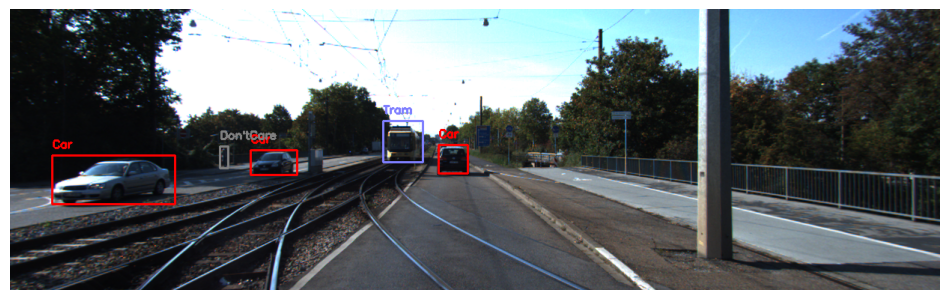

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_with_boxes(image, boxes, labels, label_names):
    # Convert tensor image to numpy array
    image = image.numpy().transpose((1, 2, 0))
    # Scale the image's pixel values to [0, 255]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

    # Define colors for different classes
    colors = {
        'Car': (255, 0, 0), 'Van': (0, 255, 0), 'Truck': (0, 0, 255),
        'Pedestrian': (255, 255, 0), 'Person_sitting': (255, 0, 255), 'Cyclist': (0, 255, 255),
        'Tram': (127, 127, 255), 'Misc': (255, 127, 127), "Don'tCare": (127, 127, 127)
    }

    # Draw boxes and labels
    for box, label in zip(boxes, labels):
        box = box.numpy()
        label = int(label)
        box = box.astype(int)
        print(label)
        label_text = label_names[label]
        color = colors.get(label_text, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label
        cv2.putText(image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define label names based on your dataset specifics
label_names = ['background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', "Don'tCare"]

# Sample call to the function
# This assumes `image` is a tensor from the dataset, `boxes` is a tensor of bounding boxes, and `labels` is a tensor of label indices
visualize_image_with_boxes(image, target['boxes'], target['labels'], label_names)


In [10]:
import os
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class KITTIDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError("Image not found at path: {}".format(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = self.img_labels.iloc[idx, 2:6].astype('float').values.reshape(-1, 4)
        labels = torch.tensor(self.img_labels.iloc[idx, 1]).unsqueeze(0)

        target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': labels}

        if self.transform:
            # Assuming the transform is compatible with this format
            image = self.transform(image=image)['image']

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = KITTIDataset('train_annotations.csv', 'KITTI/training/image_2')
val_dataset = KITTIDataset('val_annotations.csv', 'KITTI/training/image_2')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
